# Detecção de fraude de cartão de crédito

#### Este notebook testará diferentes métodos em dados distorcidos. A ideia é comparar se as técnicas de pré-processamento funcionam melhor quando há uma classe majoritária esmagadora que pode atrapalhar a eficiência do nosso modelo preditivo.

#### Você também poderá ver como aplicar a validação cruzada para ajuste de hiperparâmetros em diferentes modelos de classificação. Minha intenção é criar modelos usando:
1. Regressão Logística
2. SVMs
3. Árvores de decisão
4. Redes neurais

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

### Carregando os dados

Os dados foram obtidos no Kaggle e podem ser encontrados [aqui](https://www.kaggle.com/mlg-ulb/creditcardfraud).

In [11]:
data = pd.read_csv("./data/creditcard.csv")
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Verificando a frequência de cada classe

Number of transactions:  284807
Number of frauds:  492
Number of valid:  284315


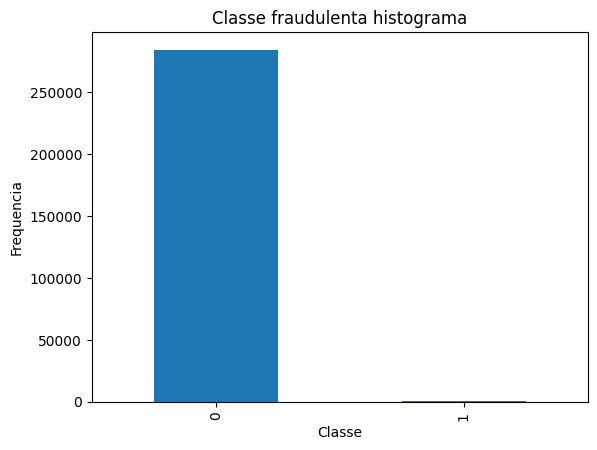

In [12]:
count_classes = pd.value_counts(data['Class'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Classe fraudulenta histograma")
plt.xlabel("Classe")
plt.ylabel("Frequencia")

print("Number of transactions: ", data.shape[0])
print("Number of frauds: ", data['Class'].value_counts()[1])
print("Number of valid: ", data['Class'].value_counts()[0])

#### Dados do dataset:
- numero de features: 30
- numero de amostras: 284.807
- numero de amostras da classe positiva: 492
- numero de amostras da classe negativa: 284.315
- proporção entre as classes: 0.172% (positivas), 99.828% (negativas)

#### Dados desbalanceados!

- Alteração da métrica de desempenho:
    - Use a matriz de confusão para calcular precisão, recuperação
    - F1score (média ponderada de recuperação de precisão)
    - Utilizar Kappa – que é uma precisão de classificação normalizada pelo desequilíbrio das classes nos dados
    - Curvas ROC - calcula a relação sensibilidade/especificidade.

- Reamostragem do conjunto de dados
    - Essencialmente, este é um método que processará os dados para ter uma proporção aproximada de 50-50.
    - Uma maneira de conseguir isso é por sobreamostragem, que consiste em adicionar cópias da classe sub-representada (melhor quando você tem poucos dados)
    - Outra é a subamostragem, que exclui instâncias da classe sobre-representada (melhor quando ele tem muitos dados)

### Abordagem

1. Não realizaremos engenharia de recursos em primeira instância. O conjunto de dados foi rebaixado para conter 30 features (28 anonimizados* + time + amount).
2. Em seguida, compararemos o que acontece quando usamos a resampling ou reamostragem e quando não a usamos. Testaremos essa abordagem usando um classificador de regressão logística simples.
3. Avaliaremos os modelos usando algumas das métricas de desempenho mencionadas acima.
4. Repetiremos o melhor método de reamostragem/não reamostragem, ajustando os parâmetros no classificador de regressão logística.
5. Finalmente realizaremos o modelo de classificações usando outros algoritmos de classificação.

# Configurando nossas variáveis ​​de entrada e destino + reamostragem.

#### 1. Normalizando a coluna de valor. A coluna do valor não está de acordo com os recursos anonimizados.

In [15]:
from sklearn.preprocessing import StandardScaler

data['normAmount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))
data = data.drop(['Time','Amount'],axis=1)
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,normAmount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403


#### 2. Atribuição de X e Y. Sem reamostragem.

#### 3. Reamostragem.
![assets/resampling.png](assets/resampling.png)
- Usaremos a abordagem undersampling, isso sera feito selecionando aleatoriamente “N” quantidade de amostra da classe majoritária, sendo “N” é o número total de registros da classe minoritária.

- Porque dessa escolha?
    - A classe majoritátia é muito grande, no qual torna o treinamento muito lento além de ser composta por em sua grande maioria de dados que não são relevantes para o modelo. Possui muito ruído ou rendundântes.




In [17]:
X = data.loc[:, data.columns != 'Class']
y = data.loc[:, data.columns == 'Class']


In [22]:
# Numero de pontos de dados na classe minoritaria

number_records_fraud = len(data[data.Class == 1])
fraud_indices = np.array(data[data.Class == 1].index)

# Selecionando os indices das classes normais
normal_indices = data[data.Class == 0].index

# Fora dos indices que escolhemos, selecione aleatoriamente "x" número (number_records_fraud)
random_normal_indices = np.random.choice(normal_indices, number_records_fraud, replace=False)
random_normal_indices = np.array(random_normal_indices)

# adicionando os dois indices
under_sample_indices = np.concatenate([fraud_indices, random_normal_indices])

# Under sample dataset
under_sample_data = data.loc[under_sample_indices, :]

X_undersample = under_sample_data.loc[:, under_sample_data.columns != 'Class']
y_undersample = under_sample_data.loc[:, under_sample_data.columns == 'Class']

# Proporções dos dados
print("Porcentagem de transações não fraudulentas: ", len(under_sample_data[under_sample_data.Class == 0]) / len(under_sample_data))
print("Porcentagem de transações fraudulentas: ", len(under_sample_data[under_sample_data.Class == 1]) / len(under_sample_data))
print("Numero total de transações: ", len(under_sample_data))

Porcentagem de transações não fraudulentas:  0.5
Porcentagem de transações fraudulentas:  0.5
Numero total de transações:  984


# Divisão de dados em conjunto de treinamento e teste. A cross validation será usada ao calcular precisões.


In [26]:
from sklearn.model_selection import train_test_split

# Dividindo os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 0)

print("Numero de transações do dataset de treino:: ", len(X_train))
print("Numero de transações do dataset de teste:: ", len(X_test))
print("Numero de total de transações: ", len(X_train)+len(X_test))

# Undersampled dataset
X_train_undersample, X_test_undersample, y_train_undersample, y_test_undersample = train_test_split(X_undersample
                                                                                                   ,y_undersample
                                                                                                   ,test_size = 0.3
                                                                                                   ,random_state = 0)
print("")
print("Numero de transações do dataset de treino: ", len(X_train_undersample))
print("Numero de transações do dataset de teste: ", len(X_test_undersample))
print("Numero de total de transações: ", len(X_train_undersample)+len(X_test_undersample))



Numero de transações do dataset de treino::  199364
Numero de transações do dataset de teste::  85443
Numero de total de transações:  284807

Numero de transações do dataset de treino:  688
Numero de transações do dataset de teste:  296
Numero de total de transações:  984


# Classificador de regressão logística - Dados subamostrados

#### Estamos muito interessados ​​na pontuação de recall, porque essa é a métrica que nos ajudará a tentar capturar as transações mais fraudulentas. Se você pensar como Precisão, Precisão e Recall funcionam para uma matriz de confusão, o recall seria o mais interessante:

- Precisão = (TP+TN)/total
- Precisão = TP/(TP+FP)
- Rechamada = TP/(TP+FN)

#### Como sabemos, devido ao desequilíbrio dos dados, muitas observações poderiam ser previstas como Falsos Negativos, sendo que prevemos uma transação normal, mas na verdade é fraudulenta. Recall captura isso.
- Obviamente, tentar aumentar o recall tende a resultar em uma diminuição da precisão. No entanto, no nosso caso, se prevermos que uma transação é fraudulenta e acaba por não o ser, não é um grande problema em comparação com o contrário.
- Poderíamos até aplicar uma função de custo ao ter FN e FP com pesos diferentes para cada tipo de erro, mas vamos deixar isso de lado por enquanto.

#### Very ad-hoc function to print K_fold_scores

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report 

def printing_Kfold_scores(x_train_data,y_train_data):
    fold = KFold(n_splits=5, shuffle=False) 

    # Different C parameters
    c_param_range = [0.01,0.1,1,10,100]

    results_table = pd.DataFrame(index = range(len(c_param_range),2), columns = ['C_parameter','Mean recall score'])
    results_table['C_parameter'] = c_param_range

    # the k-fold will give 2 lists: train_indices = indices[0], test_indices = indices[1]
    j = 0
    for c_param in c_param_range:
        print('-------------------------------------------')
        print('C parameter: ', c_param)
        print('-------------------------------------------')
        print('')

        recall_accs = []
        for iteration, indices in enumerate(fold.split(x_train_data), start=1):

            # Call the logistic regression model with a certain C parameter
            lr = LogisticRegression(C = c_param, penalty = 'l1', solver='liblinear')

            # Use the training data to fit the model. In this case, we use the portion of the fold to train the model
            # with indices[0]. We then predict on the portion assigned as the 'test cross validation' with indices[1]
            lr.fit(x_train_data.iloc[indices[0],:],y_train_data.iloc[indices[0],:].values.ravel())

            # Predict values using the test indices in the training data
            y_pred_undersample = lr.predict(x_train_data.iloc[indices[1],:].values)

            # Calculate the recall score and append it to a list for recall scores representing the current c_parameter
            recall_acc = recall_score(y_train_data.iloc[indices[1],:].values,y_pred_undersample)
            recall_accs.append(recall_acc)
            print('Iteration ', iteration,': recall score = ', recall_acc)

        # The mean value of those recall scores is the metric we want to save and get hold of.
        results_table.loc[j, 'Mean recall score'] = np.mean(recall_accs)
        j += 1
        print('')
        print('Mean recall score ', np.mean(recall_accs))
        print('')

    best_c = results_table['Mean recall score'].astype(float).idxmax()

    # Finally, we can check which C parameter is the best amongst the chosen.
    print('*********************************************************************************')
    print('Best model to choose from cross validation is with C parameter = ', results_table.loc[best_c]['C_parameter'])
    print('*********************************************************************************')
    
    return best_c


best_c = printing_Kfold_scores(X_train_undersample,y_train_undersample)

-------------------------------------------
C parameter:  0.01
-------------------------------------------

Iteration  1 : recall score =  0.9315068493150684
Iteration  2 : recall score =  0.9178082191780822
Iteration  3 : recall score =  1.0
Iteration  4 : recall score =  0.9594594594594594
Iteration  5 : recall score =  0.9545454545454546

Mean recall score  0.9526639964996129

-------------------------------------------
C parameter:  0.1
-------------------------------------------

Iteration  1 : recall score =  0.8493150684931506
Iteration  2 : recall score =  0.863013698630137
Iteration  3 : recall score =  0.9322033898305084
Iteration  4 : recall score =  0.9324324324324325
Iteration  5 : recall score =  0.8939393939393939

Mean recall score  0.8941807966651245

-------------------------------------------
C parameter:  1
-------------------------------------------

Iteration  1 : recall score =  0.8767123287671232
Iteration  2 : recall score =  0.8904109589041096
Iteration  3 : r

C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:465: 

Iteration  3 : recall score =  0.9830508474576272
Iteration  4 : recall score =  0.9459459459459459
Iteration  5 : recall score =  0.9242424242424242

Mean recall score  0.9295519531182406

*********************************************************************************
Best model to choose from cross validation is with C parameter =  0.01
*********************************************************************************


C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


#### Crie uma função para traçar uma matriz de confusão sofisticada

In [49]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Previsões no conjunto de testes e plotagem da matriz de confusão

#### Temos falado sobre o uso da métrica de recall como indicador da eficácia do nosso modelo preditivo. Embora o recall ainda seja o recall que queremos calcular, lembre-se de que os dados subamostrados não apresentam assimetria em relação a uma determinada classe, o que não torna a métrica de recall tão crítica.

Recall metric in the testing dataset:  0.9319727891156463


C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


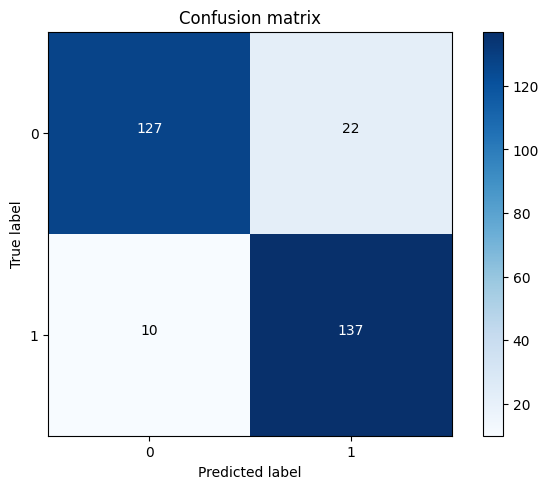

In [57]:
# Use this C_parameter to build the final model with the whole training dataset and predict the classes in the test
# dataset
lr = LogisticRegression(C=best_c, penalty='l1', solver='liblinear')
lr.fit(X_train_undersample, y_train_undersample.values.ravel())
y_pred_undersample = lr.predict(X_test_undersample.values)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_undersample,y_pred_undersample)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

#### Portanto, o modelo oferece uma precisão de recuperação de 93,2% nos dados não vistos generalizados (conjunto de teste). Não é uma porcentagem ruim para ser a primeira tentativa. No entanto, lembre-se, esta é uma medida de precisão de recall de 93,2% no conjunto de teste subamostrado.

### Estando satisfeitos com este resultado, vamos aplicar o modelo que ajustamos e testá-lo em todos os dados.

Recall metric in the testing dataset:  0.9183673469387755
Recall metric in the testing dataset:  0.9183673469387755


C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


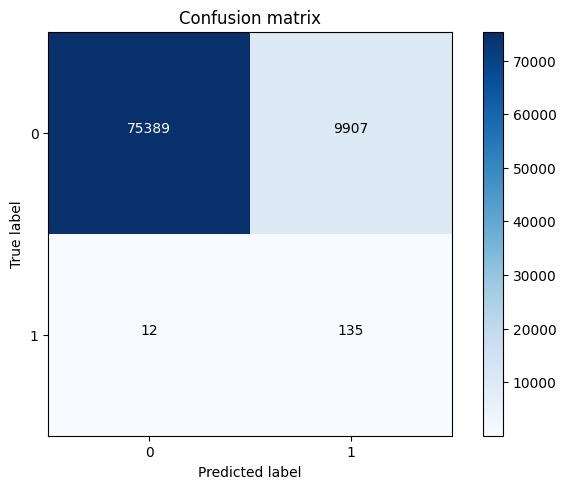

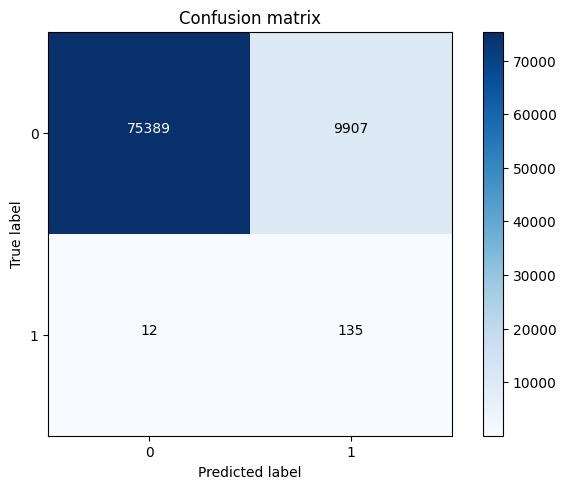

In [60]:
# Use this C_parameter to build the final model with the whole training dataset and predict the classes in the test
# dataset
lr = LogisticRegression(C=best_c, penalty='l1', solver='liblinear')
lr.fit(X_train_undersample, y_train_undersample.values.ravel())
y_pred = lr.predict(X_test.values)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", cnf_matrix[1, 1] / (cnf_matrix[1, 0] + cnf_matrix[1, 1]))

# Plot non-normalized confusion matrix
class_names = [0, 1]
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test,y_pred)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

### Ainda uma precisão de recall muito decente quando aplicada a um conjunto de dados muito maior e distorcido!

#### Podemos começar a ficar felizes com o funcionamento da abordagem inicial.

### Traçando a curva ROC e a curva Precision-Recall.

- Acho a curva de recuperação de precisão muito mais conveniente neste caso, pois nossos problemas dependem da classe "positiva" ser mais interessante do que a classe negativa, mas como calculamos a precisão de recuperação, não vou traçar as curvas de recuperação de precisão ainda.

- Curvas AUC e ROC também são interessantes para verificar se o modelo também está prevendo como um todo corretamente e não cometendo muitos erros

C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


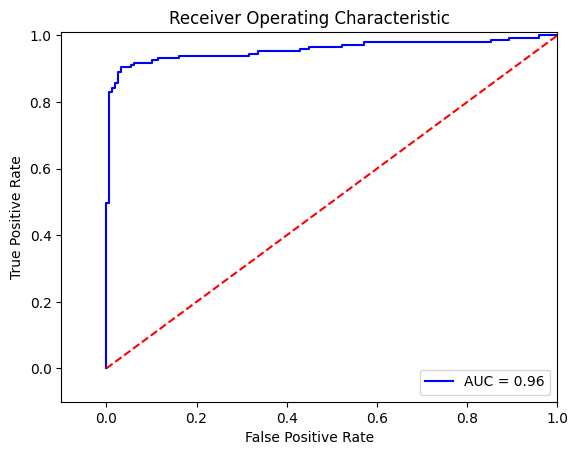

In [62]:
# ROC CURVE
lr = LogisticRegression(C=best_c, penalty='l1', solver='liblinear')
y_pred_undersample_score = lr.fit(X_train_undersample, y_train_undersample.values.ravel()).decision_function(X_test_undersample.values)

fpr, tpr, thresholds = roc_curve(y_test_undersample.values.ravel(), y_pred_undersample_score)
roc_auc = auc(fpr, tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([-0.1, 1.0])
plt.ylim([-0.1, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Um comentário adicional que seria interessante fazer é inicializar vários conjuntos de dados subamostrados e repetir o processo em loop. Lembre-se de que, para criar dados de subamostragem, obtivemos registros aleatoriamente da classe majoritária. Embora esta seja uma técnica válida, ela não representa a população real, então seria interessante repetir o processo com diferentes configurações de subamostragem e verificar se os parâmetros escolhidos anteriormente ainda são os mais eficazes. No final, a ideia é usar uma representação aleatória mais ampla de todo o conjunto de dados e contar com a média dos melhores parâmetros.

# Classificador de regressão logística - Dados distorcidos

#### Tendo testado nossa abordagem anterior, acho realmente interessante testar o mesmo processo nos dados distorcidos. Nossa intuição é que a assimetria introduzirá problemas difíceis de capturar e, portanto, fornecerá um algoritmo menos eficaz.
- Para ser justo, tendo em conta o facto de os conjuntos de dados de treino e teste serem substancialmente maiores do que os subamostrados, acredito que é necessária uma validação cruzada K-fold. Eu acho que dividindo os dados com 60% no conjunto de treinamento, 20% de validação cruzada e 20% de teste devem ser suficientes... mas vamos adotar a mesma abordagem de antes (não há mal nenhum nisso, é só que K-fold é computacionalmente mais caro)

In [63]:
best_c = printing_Kfold_scores(X_train,y_train)

-------------------------------------------
C parameter:  0.01
-------------------------------------------



C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Iteration  1 : recall score =  0.4925373134328358


C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Iteration  2 : recall score =  0.6027397260273972


C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Iteration  3 : recall score =  0.6833333333333333


C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Iteration  4 : recall score =  0.5692307692307692


C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Iteration  5 : recall score =  0.45

Mean recall score  0.5595682284048672

-------------------------------------------
C parameter:  0.1
-------------------------------------------



C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Iteration  1 : recall score =  0.5671641791044776


C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Iteration  2 : recall score =  0.6164383561643836


C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Iteration  3 : recall score =  0.6833333333333333


C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Iteration  4 : recall score =  0.5846153846153846


C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Iteration  5 : recall score =  0.525

Mean recall score  0.5953102506435158

-------------------------------------------
C parameter:  1
-------------------------------------------



C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Iteration  1 : recall score =  0.5522388059701493


C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Iteration  2 : recall score =  0.6164383561643836


C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Iteration  3 : recall score =  0.7166666666666667


C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Iteration  4 : recall score =  0.6153846153846154


C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Iteration  5 : recall score =  0.5625

Mean recall score  0.612645688837163

-------------------------------------------
C parameter:  10
-------------------------------------------



C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Iteration  1 : recall score =  0.5522388059701493


C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Iteration  2 : recall score =  0.6164383561643836


C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Iteration  3 : recall score =  0.7333333333333333


C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Iteration  4 : recall score =  0.6153846153846154


C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Iteration  5 : recall score =  0.575

Mean recall score  0.6184790221704963

-------------------------------------------
C parameter:  100
-------------------------------------------



C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Iteration  1 : recall score =  0.5522388059701493


C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Iteration  2 : recall score =  0.6164383561643836


C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Iteration  3 : recall score =  0.7333333333333333


C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Iteration  4 : recall score =  0.6153846153846154
Iteration  5 : recall score =  0.575

Mean recall score  0.6184790221704963

*********************************************************************************
Best model to choose from cross validation is with C parameter =  10.0
*********************************************************************************


C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Recall metric in the testing dataset:  0.6190476190476191


C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


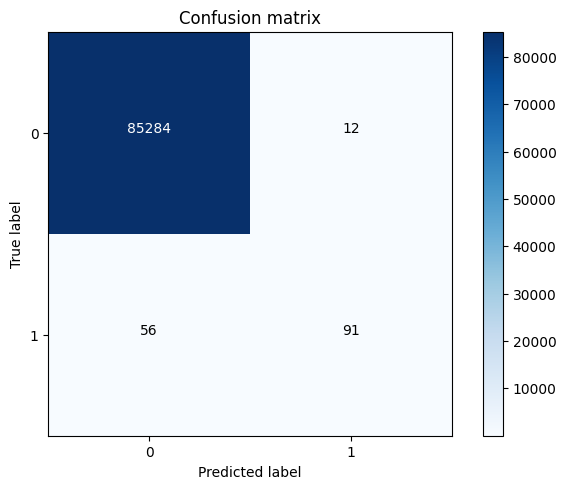

Recall metric in the testing dataset:  0.6190476190476191


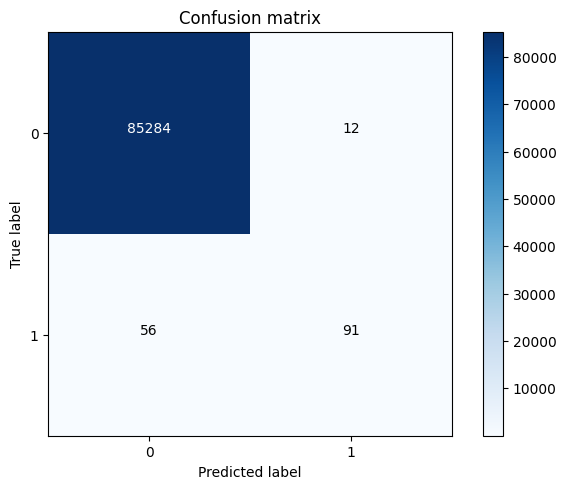

In [66]:
# Use this C_parameter to build the final model with the whole training dataset and predict the classes in the test
# dataset
lr = LogisticRegression(C=best_c, penalty='l1', solver='liblinear')
lr.fit(X_train, y_train.values.ravel())
y_pred_undersample = lr.predict(X_test.values)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_undersample)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", cnf_matrix[1, 1] / (cnf_matrix[1, 0] + cnf_matrix[1, 1]))

# Plot non-normalized confusion matrix
class_names = [0, 1]
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')
plt.show()
cnf_matrix = confusion_matrix(y_test,y_pred_undersample)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

# Antes de continuar... alterando o limite de classificação.

#### Vimos que, ao subamostrar os dados, nosso algoritmo faz um trabalho muito melhor na detecção de fraudes. Queria também mostrar como podemos ajustar a nossa classificação final alterando o limiar.
- Inicialmente, você constrói o modelo de classificação e depois prevê dados invisíveis usando-o.
- Anteriormente usamos o método "predict()" para decidir se um registro deveria pertencer a "1" ou "0".
- Existe outro método "predict_proba()".
    - Este método retorna as probabilidades de cada classe. A ideia é que, alterando o limite para atribuir um registro à classe 1, possamos controlar a precisão e a recuperação.
    
#### Vamos verificar isso usando os dados subamostrados (melhor C_param = 0,01)

C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:465: 

Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  0.9727891156462585


C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Recall metric in the testing dataset:  0.9319727891156463
Recall metric in the testing dataset:  0.8639455782312925
Recall metric in the testing dataset:  0.8231292517006803


C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Recall metric in the testing dataset:  0.7551020408163265
Recall metric in the testing dataset:  0.5918367346938775


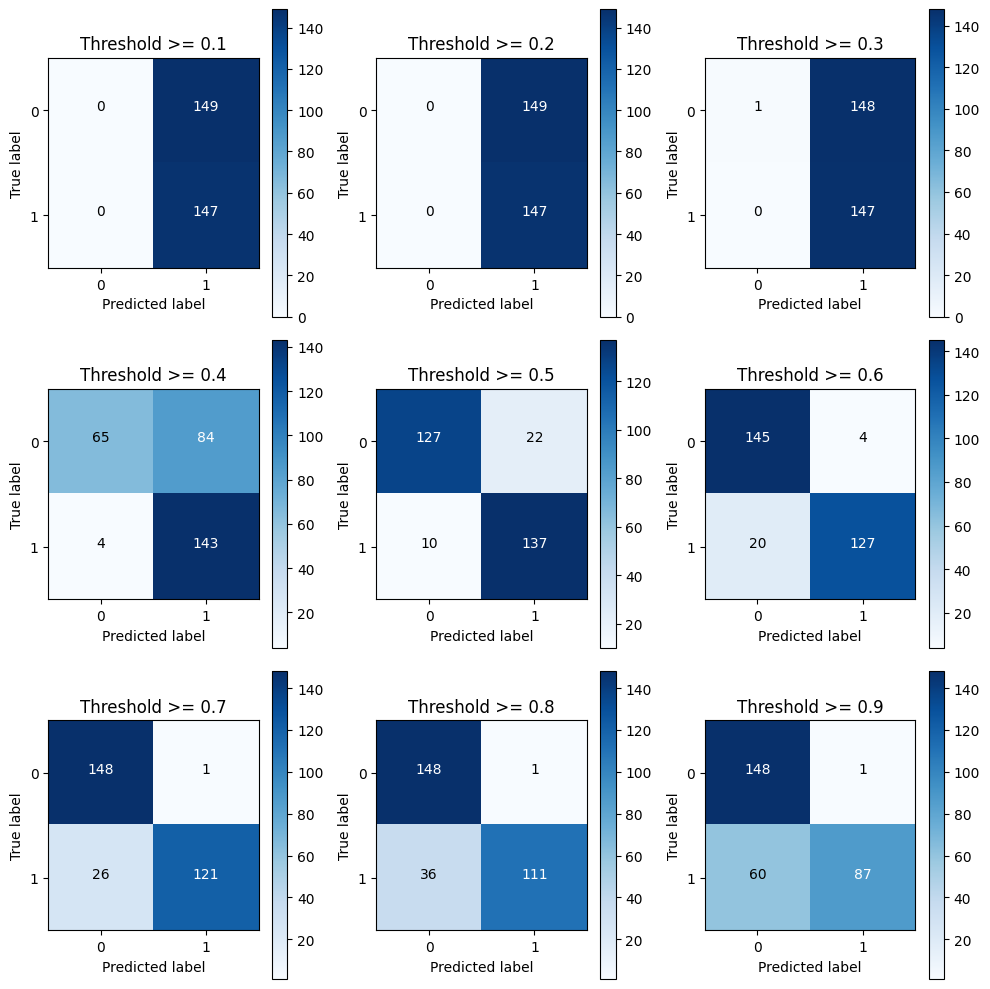

In [69]:
lr = LogisticRegression(C=0.01, penalty='l1', solver='liblinear')
lr.fit(X_train_undersample, y_train_undersample.values.ravel())
y_pred_undersample_proba = lr.predict_proba(X_test_undersample.values)

thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

plt.figure(figsize=(10, 10))

j = 1
for i in thresholds:
    lr = LogisticRegression(C=0.01, penalty='l1', solver='liblinear')
    lr.fit(X_train_undersample, y_train_undersample.values.ravel())
    y_pred_undersample_proba = lr.predict_proba(X_test_undersample.values)

    y_test_predictions_high_recall = y_pred_undersample_proba[:, 1] > i

    plt.subplot(3, 3, j)
    j += 1

    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test_undersample, y_test_predictions_high_recall)
    np.set_printoptions(precision=2)

    print("Recall metric in the testing dataset: ", cnf_matrix[1, 1] / (cnf_matrix[1, 0] + cnf_matrix[1, 1]))

    # Plot non-normalized confusion matrix
    class_names = [0, 1]
    plot_confusion_matrix(cnf_matrix, classes=class_names, title='Threshold >= %s' % i)


### O padrão é muito claro: quanto mais você diminui a probabilidade necessária para colocar um determinado item na categoria da classe "1", mais registros serão colocados naquele balde.
#### Isso implica um aumento na recuperação (queremos todos os "1"), mas, ao mesmo tempo, uma diminuição na precisão (classificamos incorretamente muitas das outras classes).
### Portanto, embora o recall seja nossa métrica de objetivo (não perder uma transação fraudulenta), também queremos manter o modelo preciso como um todo.
- Existe uma opção que acho que poderia ser bastante interessante para resolver isso. Poderíamos avaliar o custo das classificações incorretas, mas estando interessados ​​em classificar "1s" corretamente, o custo da classificação incorreta de "1s" deve ser maior do que as classificações incorretas "0". Depois disso, o algoritmo selecionaria o limite que minimiza o custo total. Uma desvantagem que vejo é que temos que selecionar manualmente o peso de cada custo... portanto, deixarei isso como uma reflexão.
- Voltando à alteração do limite, existe uma opção que é a curva Precisio-Recall. Ao ver visualmente o desempenho do modelo dependendo do limite que escolhemos, podemos investigar um ponto ideal onde a recuperação é alta o suficiente, mantendo um valor de alta precisão.

### Investigue a curva Precision-Recall e a área sob esta curva.

C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


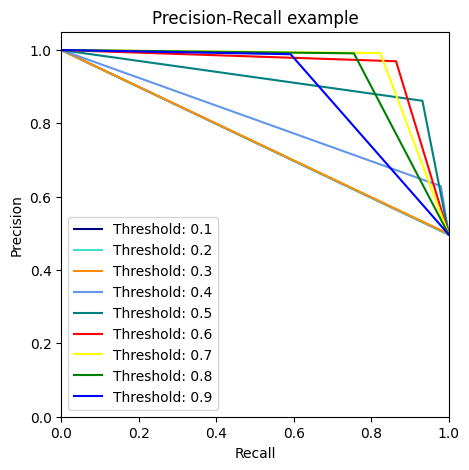

In [72]:
from itertools import cycle

lr = LogisticRegression(C=0.01, penalty='l1', solver='liblinear')
lr.fit(X_train_undersample, y_train_undersample.values.ravel())
y_pred_undersample_proba = lr.predict_proba(X_test_undersample.values)

thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'red', 'yellow', 'green', 'blue', 'black'])

plt.figure(figsize=(5, 5))

j = 1
for i,color in zip(thresholds,colors):
    y_test_predictions_prob = y_pred_undersample_proba[:,1] > i
    
    precision, recall, thresholds = precision_recall_curve(y_test_undersample,y_test_predictions_prob)
    
    # Plot Precision-Recall curve
    plt.plot(recall, precision, color=color,
                 label='Threshold: %s'%i)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall example')
    plt.legend(loc="lower left")
